# Search Parameters

In [1]:
seed = 70 # seed for NMF topic model
num_topics = 12
labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
vis_seed = 6 # seed for t-SNE visualization
vis_angle = 135 # rotation angle for visualization

# Import Modules

In [2]:
import requests
import time
import gensim
from gensim.utils import simple_preprocess
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.decomposition
import sklearn.feature_extraction
from wordcloud import WordCloud
from IPython.display import display
from collections import defaultdict

import seaborn as sns
sns.set('paper')

import logging
logging.getLogger().setLevel(logging.INFO)

# some python 3 trickery
import sys
if sys.version_info[0] >= 3:
    unicode = str


/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Useful Functions

In [3]:
def prepare_fig(w=1, h=None):
    if h is None: h = w
    figsize = (6 * w, 3 * h)
    sns.set(rc={'figure.figsize': figsize})
    fig = plt.figure(figsize=figsize)
    plt.clf()
    return fig

def top_k(mapping, k=10):
    return sorted(mapping.keys(), key=lambda x: mapping[x])[::-1][:k]

pd.set_option('display.max_rows', 250)

def plot_statistic(fun):
    count = defaultdict(int)

    for row in fun:
        if row:
            count[unicode(row)] += 1

    top_keys = top_k(count, 50)

    prepare_fig(1, 4)
    plt.xlabel("No. publications")
    plt.barh(
        range(len(top_keys)),
        [count[a] for a in top_keys])
    plt.yticks(
        range(len(top_keys)), 
        [key[:50] for key in top_keys])
    plt.show()

# Perform Query

In [4]:
# Some query examples
# "protein AND (molecular dynamics) AND year_published:[2000 TO 2018]"
# "author.display_name:(Jingjie AND Yeo) AND year_published:[2000 TO 2018]"
# "(autonomous driving) OR (self-driving car) OR (robotic car)"
# "(silk) OR (collagen) AND (biomaterial) AND (molecular dynamics)"
# "(community participatory research) AND year_published:[2021 TO 2023]"

url = 'https://api.lens.org/scholarly/search'

request_body = '''{
	"query": {
		"query_string": {
			"query": "(community participatory research) AND year_published:[2021 TO 2023]",
            "default_operator": "and"
		}
	},
    "languages": "en",
    "scroll": "1m",
    "size": 500,
    "sort": [
            {
            "year_published": "desc"
            }
     ]
}'''

headers = {'Authorization': 'Bearer YOUR_API_KEY', 'Content-Type': 'application/json'}

df_raw = pd.DataFrame()
# Recursive function to scroll through paginated results
def scroll(scroll_id, url, request_body, headers):
    global df_raw
    # Change the request_body to prepare for next scroll api call
    # Make sure to append the include fields to make faster response
    if scroll_id is not None:
        request_body = '''{"scroll_id": "%s"}''' % (scroll_id)

    # make api request
    response = requests.post(url, data=request_body, headers=headers) 

    # If rate-limited, wait for n seconds and proceed the same scroll id
    # Since scroll time is 1 minutes, it will give sufficient time to wait and proceed
    if response.status_code == requests.codes.too_many_requests:
        time.sleep(8)
        scroll(scroll_id, url, request_body, headers)
  
    # If the response is not ok here, better to stop here and debug it
    elif response.status_code != requests.codes.ok:
        print(response.json())
  
    # If the response is ok, do something with the response, take the new scroll id and iterate
    else:
        json = response.json()

        # End recursion once end of search is reached
        if not json['data']:
            return

        scroll_id = json['scroll_id'] # Extract the new scroll id from response
        
        # Store the data into a dataframe
        print(json['data'])
        df_raw = df_raw.append(pd.DataFrame.from_dict(json['data'])) 
        
        # Keep scrolling
        scroll(scroll_id, url, request_body, headers)

# start recursive scrolling
scroll(None, url, request_body, headers)

# Raw Data
df_raw = df_raw.reset_index() # make sure indexes pair with number of rows

# Filter journal articles only
df = df_raw[df_raw['publication_type'].str.contains('journal article', na=False)] 
df = df.reset_index() # make sure indexes pair with number of rows

[{'lens_id': '107-999-189-902-59X', 'title': "‘Learning for resilience': Developing community capital through flood action groups in urban flood risk settings with lower social capital", 'publication_type': 'journal article', 'year_published': 2018, 'date_published_parts': [2018, 3], 'created': '2018-05-13T00:36:39.168000+00:00', 'external_ids': [{'type': 'coreid', 'value': '323893339'}, {'type': 'doi', 'value': '10.1016/j.ijdrr.2017.10.018'}, {'type': 'magid', 'value': '2765977383'}], 'open_access': {'license': 'cc-by-nd', 'colour': 'green'}, 'authors': [{'first_name': 'Lindsey', 'last_name': 'McEwen', 'initials': 'L', 'ids': [{'type': 'magid', 'value': '1911008706'}], 'affiliations': [{'name': 'University of the West of England', 'ids': [{'type': 'magid', 'value': '178535277'}, {'type': 'grid', 'value': 'grid.6518.a'}, {'type': 'ror', 'value': 'https://ror.org/02nwg5t34'}], 'grid_id': 'grid.6518.a', 'country_code': 'GB'}]}, {'first_name': 'Andrew', 'last_name': 'Holmes', 'initials': 

[{'lens_id': '000-184-472-865-272', 'title': 'Social and environmental determinants of physical activity in urban parks: Testing a neighborhood disorder model.', 'publication_type': 'journal article', 'year_published': 2018, 'date_published': '2018-01-31T00:00:00.000000+00:00', 'date_published_parts': [2018, 1, 31], 'created': '2018-05-13T01:03:33.224000+00:00', 'external_ids': [{'type': 'doi', 'value': '10.1016/j.ypmed.2018.01.013'}, {'type': 'pmid', 'value': '29366818'}, {'type': 'magid', 'value': '2791474713'}], 'authors': [{'first_name': 'Jason A.', 'last_name': 'Douglas', 'initials': 'JA', 'ids': [{'type': 'magid', 'value': '2151236874'}], 'affiliations': [{'name': 'San Jose State University', 'ids': [{'type': 'magid', 'value': '51504820'}, {'type': 'grid', 'value': 'grid.186587.5'}, {'type': 'ror', 'value': 'https://ror.org/04qyvz380'}], 'grid_id': 'grid.186587.5', 'country_code': 'US'}]}, {'first_name': 'Maya D.', 'last_name': 'Briones', 'initials': 'MD', 'ids': [{'type': 'magid

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[{'lens_id': '000-834-217-294-160', 'title': "Teachers' perceptions of using interactive whiteboards in early years classrooms", 'publication_type': 'dissertation', 'year_published': 2017, 'date_published_parts': [2017], 'created': '2018-09-12T13:37:03.349000+00:00', 'external_ids': [{'type': 'magid', 'value': '2887088920'}], 'authors': [{'first_name': 'Karen', 'last_name': 'Lewis', 'initials': 'K', 'ids': [{'type': 'magid', 'value': '2885598242'}]}], 'fields_of_study': ['Participatory action research', 'Mathematics education', 'Psychology', 'Qualitative research', 'Affordance', 'Technology integration', 'Australian Curriculum', 'Curriculum', 'Action research', 'Information and Communications Technology'], 'languages': ['en'], 'references': [{'lens_id': '001-551-268-218-076'}, {'lens_id': '002-952-172-971-040'}, {'lens_id': '008-195-017-784-731'}, {'lens_id': '012-883-549-298-906'}, {'lens_id': '014-374-445-819-794'}, {'lens_id': '019-128-297-298-920'}, {'lens_id': '019-350-728-788-006

In [5]:
# Start processing
texts = []
for index, row in df.iterrows():
    if not pd.isna(row['title']):
        text = (row['title'] or '') + ' ' 
    
    # Skip over empty results
    if not pd.isna(row['abstract']):
        text = text + (row['abstract'] or '')
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9]', ' ', text) # Replace punctation by spaces
    texts.append([w for w in text.split(' ') if w]) # Split on spaces, remove empty items

# Analysis

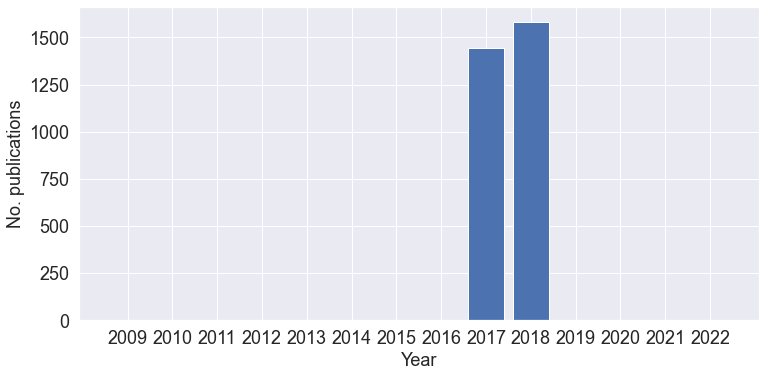

In [6]:
# Publications per year
year_count = defaultdict(int)

for index, row in df.iterrows():
    # Skip over empty results
    if not pd.isna(row['year_published']):
        year_count[int(row['year_published'])] += 1
     
years = range(2009, 2023)

prepare_fig(1.8, 1.8)
plt.ylabel("No. publications",fontsize=18)
plt.xlabel("Year",fontsize=18)
plt.bar(
    years,
    [year_count[y] for y in years])
plt.xticks(years);
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig('years_ad.pdf')

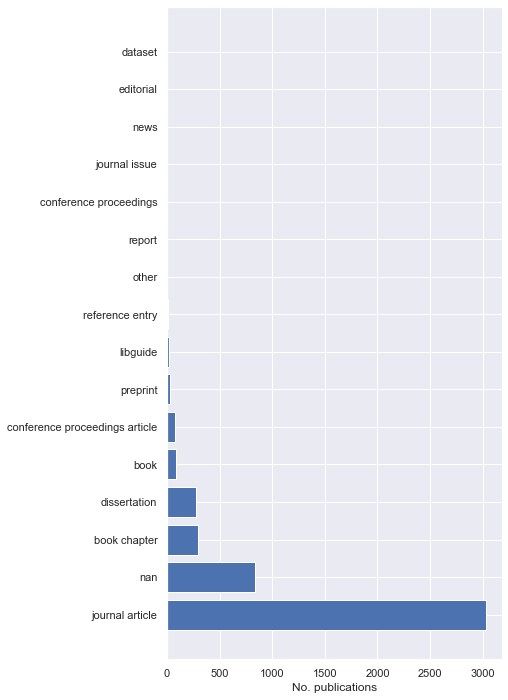

In [7]:
# Publications per type
plot_statistic(df_raw['publication_type'])

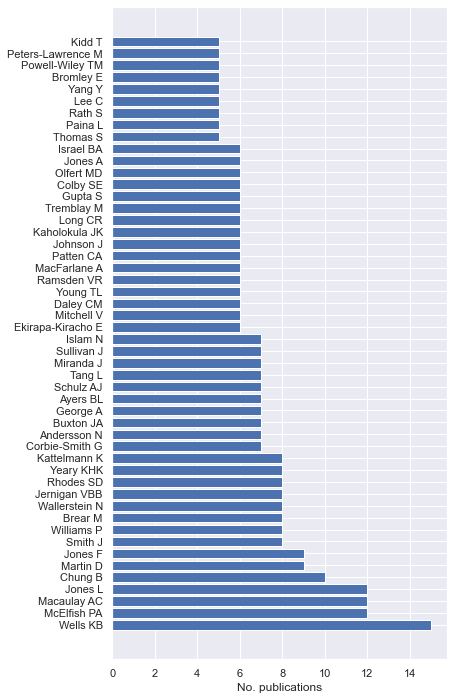

In [8]:
# Publications per author
author = []
for a in df['authors']:
    try:
        for b in a:
            try:
                author.append(b['last_name'] + ' ' + b['initials'])
            except Exception:
                continue
    except Exception:
        continue

plot_statistic(author)

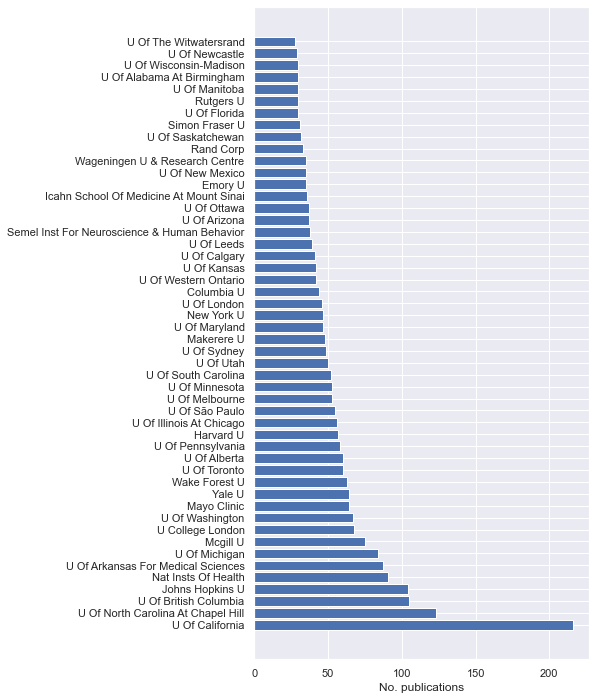

In [9]:
# Publications per institute
def clean_affiliation(name):
    name = unicode(name).title()
    pairs = [
        ['University', 'U'],
        ['Universitat', 'U'],
        ['Laboratories', 'Lab'],
        ['Laboratory', 'Lab'],
        ['National', 'Nat'],
        ['Corporation', 'Corp'],
        ['Technology', 'Tech'],
        ['Institute', 'Inst'],
        ['And', '&'],
        ['Education', 'Ed'],
        ['Engineering', 'Eng'],
        ['Mechanical', 'Mech'],
    ]
    
    for needle, replacement in pairs:
        name = name.replace(needle, replacement)
    return name

inst = []
for a in df['authors']:
    try:
        for b in a:
        
            try:
                b['affiliations']
            except KeyError:
                continue
        
            for c in b['affiliations']:
                affil = clean_affiliation(c['name'].split(',')[0])
                inst.append(affil)
    except Exception:
        continue
        
plot_statistic(inst)

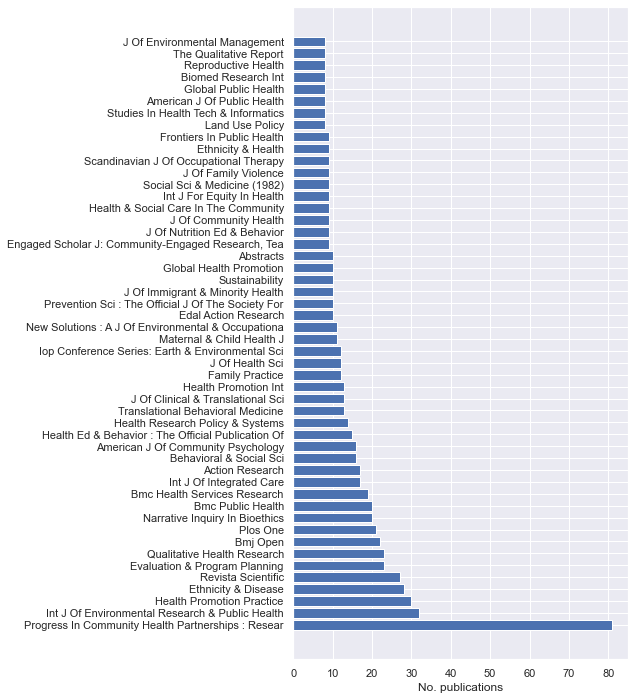

In [10]:
# Publications per publication source, conference/journal
def clean_journal(name):
    name = unicode(name).title()
    pairs = [
        ['Journal', 'J'],
        ['Nature', 'Nat'],
        ['Communications', 'Comm'],
        ['Materials', 'Mat'],
        ['Chemistry', 'Chem'],
        ['Advanced', 'Adv'],
        ['Technology', 'Tech'],
        ['Institute', 'Inst'],
        ['And', '&'],
        ['Education', 'Ed'],
        ['Engineering', 'Eng'],
        ['Mechanical', 'Mech'],
        ['International', 'Int'],
        ['Biomaterials', 'Biomat'],
        ['Science', 'Sci'],
    ]
    
    for needle, replacement in pairs:
        name = name.replace(needle, replacement)
    return name

pub_name = []
for a in df['source']:
    try:
        a['title']
    except KeyError:
        continue
        
    pub_name.append(clean_journal(a['title']))
            
plot_statistic(pub_name)


# Topic Modeling
## Preprocessing

In [11]:
# Load stopwords, bigrams, and stem rules
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import spacy
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=['ner'])

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.feature_extraction import text
stop_words = text.ENGLISH_STOP_WORDS.union(stop_words)

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

data_words = list(sent_to_words(texts))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

[nltk_data] Downloading package punkt to /Users/Angela/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Angela/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [12]:
# Print common words
one_count = defaultdict(int)

for line in data_words_nostops:
    for a in line:
        one_count[a] += 1
        
print('Top words')
display(pd.DataFrame(
    [(w, one_count[w]) for w in top_k(one_count, 250)],
    columns=['word', 'count']))

Top words


word  count
0         community   7584
1          research   6417
2            health   5049
3     participatory   4003
4             study   3110
5             based   2997
6            social   2266
7       communities   1881
8       development   1835
9              data   1731
10             care   1665
11         approach   1534
12            local   1483
13          process   1345
14            using   1335
15        knowledge   1317
16     participants   1306
17          results   1277
18           people   1264
19             used   1262
20           action   1248
21     intervention   1215
22          methods   1192
23              use   1170
24          project   1164
25       management   1161
26           design   1146
27    participation   1114
28         analysis   1098
29           public   1067
30            women   1019
31          program    997
32            group    984
33        education    956
34          support    927
35   implementation    910
36       engagement    902
37         learning    830
38      researchers    822
39              new    821
40      qualitative    812
41            model    808
42           groups    774
43            paper    773
44               la    765
45           change    756
46         findings    724
47          members    723
48    interventions    715
49             work    714
50        conducted    714
51         practice    712
52       strategies    711
53            rural    702
54            focus    700
55            level    693
56         planning    690
57      information    685
58         children    679
59         services    676
60       activities    672
61            needs    670
62     stakeholders    667
63             risk    660
64         cultural    648
65          related    643
66        practices    638
67       interviews    627
68          article    626
69          studies    623
70            urban    622
71              key    619
72       challenges    614
73             case    607
74           policy    604
75         outcomes    599
76          factors    595
77            youth    592
78           cancer    592
79    environmental    592
80        including    590
81        potential    582
82             high    580
83             food    578
84              hiv    577
85       approaches    576
86        framework    574
87           impact    573
88       evaluation    570
89      experiences    566
90           method    562
91          quality    560
92         students    555
93             self    553
94       indigenous    550
95          improve    548
96    understanding    546
97             jats    545
98       prevention    534
99             need    534
100   communication    532
101          school    528
102         service    528
103         context    526
104       processes    524
105       resources    523
106       developed    520
107            life    518
108            cbpr    509
109        evidence    500
110      identified    491
111          access    487
112       important    486
113      experience    486
114      population    485
115          mental    483
116            role    483
117        training    473
118            time    472
119           areas    470
120         develop    468
121       effective    466
122        identify    464
123        physical    454
124       different    454
125         systems    451
126        academic    448
127        projects    445
128        building    445
129        included    439
130        barriers    439
131        programs    433
132          living    433
133          future    433
134     sustainable    431
135         address    431
136             low    429
137          family    427
138          making    426
139     partnership    425
140         provide    424
141      government    423
142         patient    423
143          survey    422
144      university    420
145           years    419
146        activity    418
147              en

In [13]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Print common bigrams
two_count = defaultdict(int)

for line in data_words_bigrams:
    for a, b in zip(line, line[1:]):
        two_count[a, b] += 1
            
print('Top bigrams')
display(pd.DataFrame(
    [(w, two_count[w]) for w in top_k(two_count, 250)],
    columns=['bigram', 'count']))

Top bigrams


bigram  count
0                  (community, based)   1398
1           (participatory, research)    981
2              (based, participatory)    797
3                  (action, research)    726
4             (participatory, action)    604
5                    (mental, health)    363
6                      (health, care)    361
7                (community, members)    340
8                    (public, health)    307
9                       (case, study)    289
10                (community, health)    240
11            (community, engagement)    232
12                (health, promotion)    203
13                 (health, research)    201
14         (community, participation)    201
15              (health, disparities)    198
16                (research, project)    196
17                   (research, cbpr)    189
18                  (data, collected)    164
19                  (evidence, based)    162
20               (research, approach)    148
21                 (health, services)    141
22              (community, academic)    138
23               (local, communities)    132
24                 (local, community)    129
25          (participatory, approach)    124
26            (qualitative, research)    124
27               (community, engaged)    121
28                 (using, community)    119
29                (research, methods)    119
30                    (primary, care)    117
31             (using, participatory)    117
32                 (health, literacy)    116
33                     (focus, group)    114
34                  (based, research)    114
35                    (social, media)    111
36                    (quality, life)    110
37                (research, process)    110
38                    (research, par)    109
39              (community, partners)    104
40                  (social, capital)    104
41         (jats_italic, jats_italic)    103
42                   (research, team)    103
43           (community, development)    103
44               (rural, communities)    100
45         (focus, group_discussions)     99
46         (sustainable, development)     97
47                 (research, design)     95
48                  (social, support)     94
49            (participatory, design)     92
50                  (research, study)     91
51          (indigenous, communities)     90
52                    (older, people)     88
53               (qualitative, study)     88
54                 (health, outcomes)     88
55                (health, education)     87
56                (content, analysis)     85
57                 (community, level)     85
58        (participatory, approaches)     82
59                (qualitative, data)     82
60               (community, leaders)     82
61                    (case, studies)     81
62                 (self, management)     80
63              (research, community)     80
64          (participatory, planning)     79
65                 (study, conducted)     79
66                   (purpose, study)     78
67      (semi_structured, interviews)     78
68                 (future, research)     77
69                   (cbpr, approach)     76
70                    (risk, factors)     76
71                 (research, method)     75
72                    (health, needs)     74
73                        (land, use)     73
74                   (data, analysis)     73
75                   (health, equity)     73
76                  (improve, health)     73
77              (research, conducted)     73
78         (community, participatory)     72
79                  (health, workers)     71
80              (community, research)     71
81            (public, participation)     69
82                   (health, social)     69
83          (stakeholder, engagement)     68
84                   (results, study)     67
85                      (study, aims)     66
86                (engaged, research)     65
87                (local, government)     64
88                  (healt

In [14]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

report_sentences_lemma = [' '.join(w) for w in data_lemmatized]

large_string = ' '.join(report_sentences_lemma)

## Create Dictionary

In [15]:
dic = gensim.corpora.Dictionary(data_lemmatized)
dic.filter_extremes(0, 0.5) # Remove 
dic.filter_extremes(5, 1)   # 
corpus = [dic.doc2bow(line) for line in data_lemmatized]

print('papers: {}'.format(len(corpus)))
print('dictionary size: {}'.format(len(dic)))

papers: 3029
dictionary size: 4708


## Topic Modeling

In [16]:
# Create frequency matrix
n, m = len(corpus), len(dic)
matrix = np.zeros((n, m))

for i, row in enumerate(corpus):
    for j, freq in row:
        matrix[i,j] = freq
        

In [17]:
# Run TFIDF model
tfidf_model = sklearn.feature_extraction.text.TfidfTransformer()
tfidf_matrix = tfidf_model.fit_transform(matrix).toarray()

In [18]:
nmf_model = sklearn.decomposition.NMF(
    n_components=num_topics,
    random_state=seed,
    tol=1e-9,
    max_iter=500,
    verbose=True)

# Train model
doc2topic = nmf_model.fit_transform(tfidf_matrix)
topic2token = nmf_model.components_

topic_norm = np.sum(topic2token, axis=1)
topic2token /= topic_norm[:,np.newaxis]
doc2topic *= topic_norm[np.newaxis,:]

doc_norm = np.sum(doc2topic, axis=1)
doc2topic /= doc_norm[:,np.newaxis]

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


violation: 1.0
violation: 0.4693834087248735
violation: 0.325480906738665
violation: 0.23731330891730043
violation: 0.16284650946988288
violation: 0.1071944189620342
violation: 0.07190841830124262
violation: 0.05137504517893415
violation: 0.03810532444128122
violation: 0.029286061597981156
violation: 0.024001905010393888
violation: 0.020507471330113977
violation: 0.018021406164032482
violation: 0.016201092192118266
violation: 0.014811056030298942
violation: 0.013677276612967465
violation: 0.01273748969011924
violation: 0.011960811480681576
violation: 0.011272128789952882
violation: 0.010676957115092572
violation: 0.01017066009021239
violation: 0.00973636241772735
violation: 0.009330464924749841
violation: 0.008950808532176285
violation: 0.008598034717007829
violation: 0.008278673111185778
violation: 0.007985896174196093
violation: 0.007741952695024965
violation: 0.007523000017247807
violation: 0.007313272895921511
violation: 0.007114287306509202
violation: 0.006940134349880331
violatio

violation: 7.799261820058309e-06
violation: 7.614544110340855e-06
violation: 7.434211255800922e-06
violation: 7.25815683925336e-06
violation: 7.086282640132696e-06
violation: 6.918486062829566e-06
violation: 6.754671289061896e-06
violation: 6.594740261581799e-06
violation: 6.438600112814813e-06
violation: 6.286162192670897e-06
violation: 6.1373389255872456e-06
violation: 5.9920429758830066e-06
violation: 5.850190388383052e-06
violation: 5.711699440402738e-06
violation: 5.576490311397494e-06
violation: 5.444485287250003e-06
violation: 5.315608796799543e-06
violation: 5.189786550617683e-06
violation: 5.066945885755368e-06
violation: 4.9470161367727205e-06
violation: 4.82994071271936e-06
violation: 4.715756477868073e-06
violation: 4.60422186092662e-06
violation: 4.495289888638121e-06
violation: 4.388920536193374e-06
violation: 4.28506806613655e-06
violation: 4.183675440644356e-06
violation: 4.084684108250454e-06
violation: 3.988037100932499e-06
violation: 3.893619802469294e-06
violation: 

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [19]:
rows = []

for label, vec in zip(labels, topic2token):
    rows.append([label] + ['{} ({:.2})'.format(dic[i], vec[i]) for i in np.argsort(vec)[::-1][:10]])

# Each row is a topic, columns are words ordered by weight 
pd.DataFrame(rows)

0                     1                    2                       3   \
0   A        social (0.012)     process (0.0072)  participation (0.0066)   
1   B        health (0.089)       mental (0.019)      promotion (0.0089)   
2   C  intervention (0.049)       trial (0.0089)          group (0.0081)   
3   D    management (0.016)       forest (0.012)           local (0.011)   
4   E          care (0.047)      patient (0.032)         service (0.014)   
5   F          youth (0.11)   photovoice (0.012)           action (0.01)   
6   G       student (0.049)       school (0.041)         teacher (0.022)   
7   H         woman (0.065)    violence (0.0092)            man (0.0081)   
8   I       program (0.074)  development (0.014)      evaluation (0.013)   
9   J          food (0.065)    indigenous (0.03)         system (0.0083)   
10  K         child (0.072)        family (0.02)          parent (0.019)   
11  L   partnership (0.036)     academic (0.021)         partner (0.014)   

                       4                         5                       6   \
0        project (0.0064)           action (0.0064)    development (0.0064)   
1          public (0.008)           service (0.008)      disparity (0.0077)   
2     participant (0.008)           design (0.0073)         church (0.0069)   
3          water (0.0077)          village (0.0076)    conservation (0.007)   
4       provider (0.0083)          primary (0.0068)    stakeholder (0.0066)   
5   young_people (0.0097)           engage (0.0087)       violence (0.0083)   
6        education (0.02)             learn (0.015)       learning (0.0097)   
7          gender (0.007)  cervical_cancer (0.0064)     experience (0.0062)   
8   implementation (0.01)         training (0.0096)    participant (0.0084)   
9       cultural (0.0081)         knowledge (0.008)  food_security (0.0078)   
10       caregiver (0.01)           mother (0.0087)         school (0.0082)   
11     engagement (0.014)        researcher (0.013)          engage (0.012)   

                      7                           8                    9   \
0        design (0.0059)             public (0.0058)     approach (0.005)   
1      literacy (0.0076)            improve (0.0071)      policy (0.0064)   
2       control (0.0068)  physical_activity (0.0067)  prevention (0.0066)   
3          area (0.0069)               land (0.0056)    resource (0.0056)   
4    healthcare (0.0066)             family (0.0065)     quality (0.0064)   
5    prevention (0.0074)         empowerment (0.007)     project (0.0066)   
6   educational (0.0094)             action (0.0085)    teaching (0.0062)   
7          risk (0.0058)               live (0.0052)       group (0.0051)   
8         pilot (0.0065)         curriculum (0.0061)   implement (0.0055)   
9   traditional (0.0064)          nutrition (0.0059)  production (0.0056)   
10        young (0.0077)               year (0.0064)       early (0.0063)   
11          cbpr (0.011)             project (0.011)      member (0.0089)   

                            10  
0              people (0.0046)  
1              access (0.0061)  
2      implementation (0.0063)  
3       environmental (0.0055)  
4              people (0.0063)  
5          researcher (0.0059)  
6            practice (0.0062)  
7               sexual (0.005)  
8              result (0.0045)  
9         environment (0.0055)  
10  physical_activity (0.0059)  
11        stakeholder (0.0079)

Topic 0 (A)
Topic 1 (B)
Topic 2 (C)
Topic 3 (D)
Topic 4 (E)
Topic 5 (F)
Topic 6 (G)
Topic 7 (H)
Topic 8 (I)
Topic 9 (J)
Topic 10 (K)
Topic 11 (L)


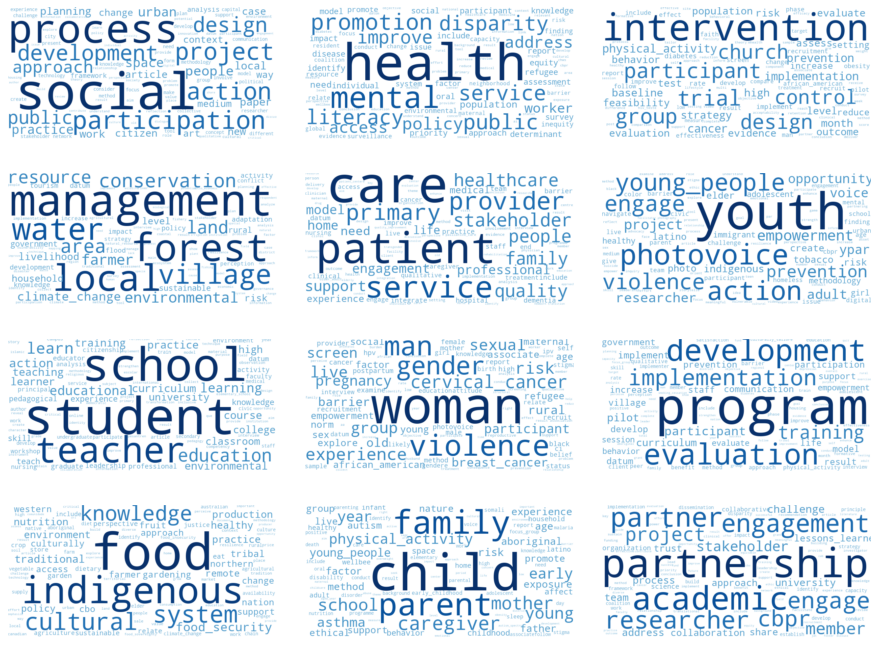

In [20]:
prepare_fig(2, 3)
for index in range(num_topics):
    mapping = dict()
    for i in np.argsort(topic2token[index])[::-1][:100]:
        if topic2token[index,i] > 0:
            mapping[dic[i]] = topic2token[index,i]
    
    def get_color(word, **kwargs):
        weight = kwargs['font_size'] / 60.0 * 0.6 + 0.4
        r, g, b = plt.get_cmap('Blues')(weight)[:3]
        return 'rgb(%s, %s, %s)' % (int(r * 255), int(g * 255), int(b * 255))
    
    wc = WordCloud(
        prefer_horizontal=True,
        max_font_size=75,
        #width=395,
        #height=250,
        scale=2,
        background_color='white', 
        color_func=get_color, 
        relative_scaling=0.5)
    wc.fit_words(mapping)
    
    print('Topic {} ({})'.format(index, labels[index]))
    plt.subplot(4, 3, index + 1)
    plt.imshow(wc.to_array(), interpolation='bilinear')
    plt.xticks([])
    plt.yticks([])
    
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0.1)
plt.show()


## Visualization

/Users/Angela/opt/anaconda3/envs/pyblio/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 3029 samples in 0.000s...
[t-SNE] Computed neighbors for 3029 samples in 0.120s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3029
[t-SNE] Computed conditional probabilities for sample 2000 / 3029
[t-SNE] Computed conditional probabilities for sample 3000 / 3029
[t-SNE] Computed conditional probabilities for sample 3029 / 3029
[t-SNE] Mean sigma: 0.074091
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.417755
[t-SNE] KL divergence after 1000 iterations: 1.409462


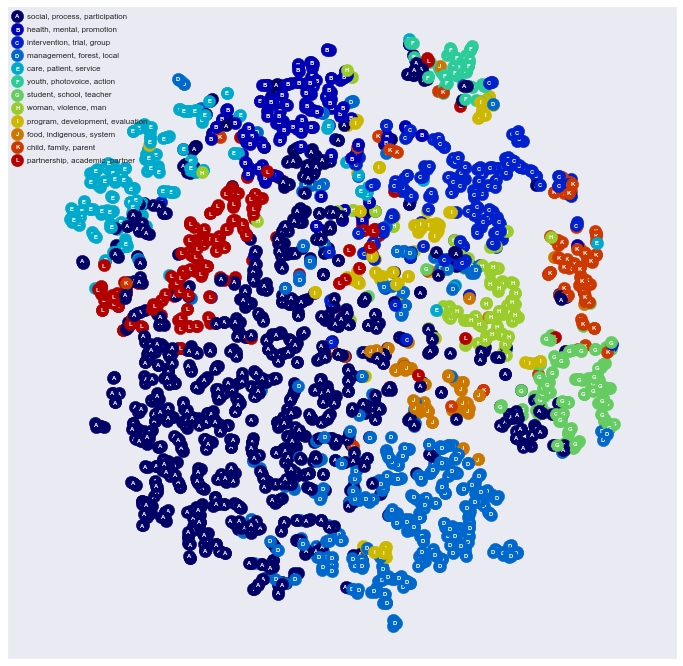

In [21]:
import sklearn.manifold
import sklearn.metrics.pairwise
from sklearn.decomposition import TruncatedSVD

def draw_dot(p, t, zorder=0):
    color = plt.get_cmap('jet')(float(t) / num_topics)
    color = 0.8 * np.array(color)[:3]
    
    plt.scatter(
        p[0], 
        p[1],
        s=150,
        c=[color],
        marker='o',
        linewidth=0.5,
        zorder=zorder)
    
    plt.text(
        p[0], 
        p[1],
        labels[t],
        fontsize=6,
        color='1',
        va='center',
        ha='center',
        fontweight='bold',
        zorder=zorder + 1)

# Lower dimensionality of original frequency matrix to improve cosine distances for visualization
reduced_matrix = TruncatedSVD(
    n_components=10, 
    random_state=seed
).fit_transform(tfidf_matrix)

# Learn model, tune perplexity value according to complexity of data
model = sklearn.manifold.TSNE(
    verbose=True,
    metric='cosine',
    random_state=vis_seed,
    perplexity=5)
pos = model.fit_transform(reduced_matrix)

# Rotate visualization
theta = np.deg2rad(vis_angle + 60)
R = np.array([[np.cos(theta), np.sin(theta)], 
              [-np.sin(theta), np.cos(theta)]])
pos = np.dot(pos, R)

# Resize so xy-position is between 0.05 and 0.95
pos -= (np.amin(pos, axis=0) + np.amax(pos, axis=0)) / 2
pos /= np.amax(np.abs(pos))
pos = (pos * 0.5) + 0.5
pos = (pos * 0.9) + 0.05

prepare_fig(2, 4)
plt.xticks([])
plt.yticks([])
plt.xlim(0, 1)
plt.ylim(0, 1)
zorder = 0

# Draw dots
for i in np.random.permutation(len(doc2topic)):
    topic_id = np.argmax(doc2topic[i])
    draw_dot(pos[i], topic_id, zorder)
    zorder += 2

# Draw legend
for i in range(num_topics):    
    y = 0.985 - i * 0.02
    label = ', '.join(dic[w] for w in np.argsort(topic2token[i])[::-1][:3])

    draw_dot([0.015, y], i)
    plt.text(0.03, y, label, ha='left', va='center', fontsize=8, zorder=zorder)
    zorder += 1

plt.show()

(-0.5, 1499.5, 999.5, -0.5)

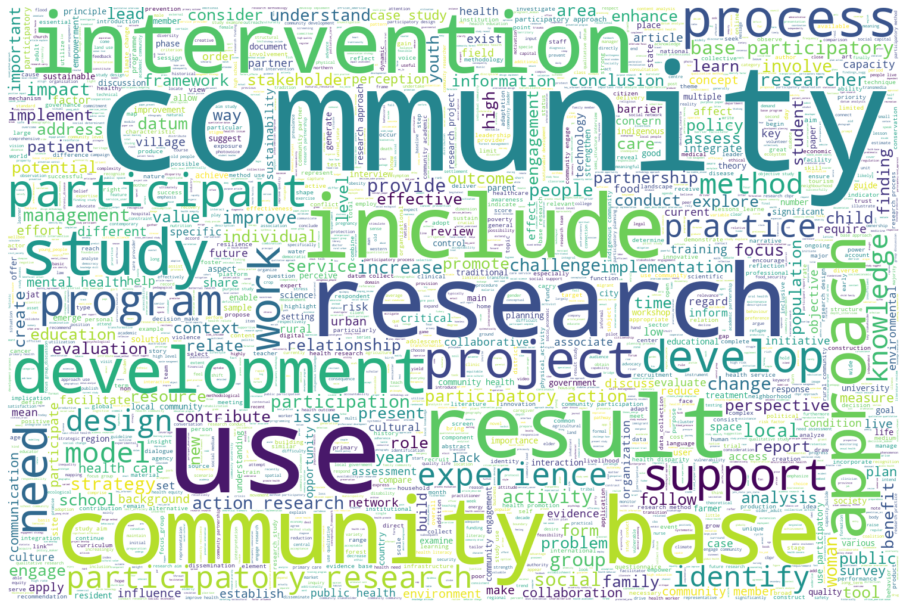

In [22]:
# Do an overall wordcloud
word_cloud = WordCloud(
    background_color="white",
    max_words=5000,
    width=1500,
    height=1000,
    stopwords=stop_words,
    contour_width=3,
    contour_color='steelblue'
)

# display our wordcloud across all records
plt.figure(figsize=(16,16))
word_cloud.generate(large_string)
word_cloud.to_file("all_words.png")
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")